# Locality Sensitive Hashing

Locality Sensitive Hashing (LSH) provides for a fast, efficient approximate nearest neighbor search. The algorithm scales well with respect to the number of data points as well as dimensions.

In this assignment, you will
* Implement the LSH algorithm for approximate nearest neighbor search
* Examine the accuracy for different documents by comparing against brute force search, and also contrast runtimes
* Explore the role of the algorithm’s tuning parameters in the accuracy of the method

## Import necessary packages

In [1]:
import numpy as np                                             # dense matrices
import pandas as pd                                            # see below for install instruction
import json
from scipy.sparse import csr_matrix                            # sparse matrices
from sklearn.metrics.pairwise import pairwise_distances        # pairwise distances
from copy import copy                                          # deep copies
import matplotlib.pyplot as plt                                # plotting
%matplotlib inline

'''compute norm of a sparse vector
   Thanks to: Jaiyam Sharma'''
def norm(x):
    sum_sq=x.dot(x.T)
    norm=np.sqrt(sum_sq)
    return(norm)

## Load in the Wikipedia dataset

In [2]:
wiki = pd.read_csv('people_wiki.csv')

## Extract TF-IDF matrix

For the remainder of the assignment, we will use sparse matrices. Sparse matrices are matrices) that have a small number of nonzero entries. A good data structure for sparse matrices would only store the nonzero entries to save space and speed up computation. SciPy provides a highly-optimized library for sparse matrices. Many matrix operations available for NumPy arrays are also available for SciPy sparse matrices.We first convert the TF-IDF column (in dictionary format) into the SciPy sparse matrix format.

In [3]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)
    
corpus = load_sparse_csr('people_wiki_tf_idf.npz')

In [4]:
with open('people_wiki_map_index_to_word.json') as people_wiki_map_index_to_word:    
    map_index_to_word = json.load(people_wiki_map_index_to_word)

In [5]:
assert corpus.shape == (59071, 547979)
print('Check passed correctly!')

Check passed correctly!


## Train an LSH model

The idea behind LSH is to translate the sign of our tf-idf scores into a binary index (1 or 0) by using seeing if our score falls above or below a randomly defined line. This <a href="http://ethen8181.github.io/machine-learning/recsys/content_based/lsh_text.html">link</a> is helpful for understanding LSH and our code in more detail.


LSH performs an efficient neighbor search by randomly partitioning all reference data points into different bins. Today we will build a popular variant of LSH known as <strong>random binary projection</strong>, which approximates cosine distance. There are other variants we could use for other choices of distance metrics.

The first step is to generate a collection of random vectors from the standard Gaussian distribution.

In [6]:
def generate_random_vectors(dim, n_vectors):
    return np.random.randn(dim, n_vectors)

To visualize these Gaussian random vectors, let's look at an example in low-dimensions.  Below, we generate 3 random vectors each of dimension 5.

In [7]:
# Generate 3 random vectors of dimension 5, arranged into a single 5 x 3 matrix.
generate_random_vectors(n_vectors=3, dim=5)

array([[-0.69475045, -0.10938364, -0.38732545],
       [ 0.52752469, -0.66823119, -1.32477185],
       [ 0.8872573 , -0.16472864,  2.52257273],
       [ 1.55180904, -2.04564588, -1.6399799 ],
       [ 1.30515546, -0.70360141,  0.02536907]])

We now generate random vectors of the same dimensionality as our vocubulary size (547979).  Each vector can be used to compute one bit in the bin encoding.  We generate 16 vectors, leading to a 16-bit encoding of the bin index for each document.

In [8]:
# Generate 16 random vectors of dimension 547979
np.random.seed(0)
n_vectors = 16
random_vectors = generate_random_vectors(corpus.shape[1], n_vectors)
random_vectors.shape

(547979, 16)

Next, we partition data points into bins. Instead of using explicit loops, we'd like to utilize matrix operations for greater efficiency. Let's walk through the construction step by step.

We'd like to decide which bin document 0 should go. Since 16 random vectors were generated in the previous cell, we have 16 bits to represent the bin index. The first bit is given by the sign of the dot product between the first random vector and the document's TF-IDF vector.

In [9]:
sample = corpus[0] # vector of tf-idf values for document 0
bin_indices_bits = sample.dot(random_vectors[:,0]) >= 0
bin_indices_bits

array([ True])

Similarly, the second bit is computed as the sign of the dot product between the second random vector and the document vector.

In [10]:
sample.dot(random_vectors[:, 1]) >= 0 # True if positive sign; False if negative sign

array([ True])

We can compute all of the bin index bits at once as follows. Note the absence of the explicit `for` loop over the 16 vectors. Matrix operations let us batch dot-product computation in a highly efficent manner, unlike the `for` loop construction. Given the relative inefficiency of loops in Python, the advantage of matrix operations is even greater.

In [11]:
sample.dot(random_vectors) >= 0 # should return an array of 16 True/False bits

array([[ True,  True, False, False, False,  True,  True, False,  True,
         True,  True, False, False,  True, False,  True]])

In [12]:
np.array(sample.dot(random_vectors) >= 0, dtype=int) # display index bits in 0/1's

array([[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1]])

All documents that obtain exactly this vector will be assigned to the same bin. We'd like to repeat the identical operation on all documents in the Wikipedia dataset and compute the corresponding bin indices. Again, we use matrix operations  so that no explicit loop is needed.

In [13]:
corpus[0:2].dot(random_vectors) >= 0 # compute bit indices of first two documents

array([[ True,  True, False, False, False,  True,  True, False,  True,
         True,  True, False, False,  True, False,  True],
       [ True, False, False, False,  True,  True, False,  True,  True,
        False,  True, False,  True, False, False,  True]])

In [14]:
corpus.dot(random_vectors) >= 0 # compute bit indices of ALL documents

array([[ True,  True, False, ...,  True, False,  True],
       [ True, False, False, ..., False, False,  True],
       [False,  True, False, ...,  True, False,  True],
       ...,
       [ True,  True, False, ...,  True,  True,  True],
       [False,  True,  True, ...,  True, False,  True],
       [ True, False,  True, ..., False, False,  True]])

We're almost done! To make it convenient to refer to individual bins, we convert each binary bin index into a single integer: 
```
Bin index                      integer
[0,0,0,0,0,0,0,0,0,0,0,0]   => 0
[0,0,0,0,0,0,0,0,0,0,0,1]   => 1
[0,0,0,0,0,0,0,0,0,0,1,0]   => 2
[0,0,0,0,0,0,0,0,0,0,1,1]   => 3
...
[1,1,1,1,1,1,1,1,1,1,0,0]   => 65532
[1,1,1,1,1,1,1,1,1,1,0,1]   => 65533
[1,1,1,1,1,1,1,1,1,1,1,0]   => 65534
[1,1,1,1,1,1,1,1,1,1,1,1]   => 65535 (= 2^16-1)
```
By the [rules of binary number representation](https://en.wikipedia.org/wiki/Binary_number#Decimal), we just need to compute the dot product between the document vector and the vector consisting of powers of 2:

In [15]:
index_bits = (sample.dot(random_vectors) >= 0)
powers_of_two = (1 << np.arange(15, -1, -1))
print(index_bits)
print(powers_of_two)
print(index_bits.dot(powers_of_two))

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]]
[32768 16384  8192  4096  2048  1024   512   256   128    64    32    16
     8     4     2     1]
[50917]


Since it's the dot product again, we batch it with a matrix operation:

In [16]:
index_bits = sample.dot(random_vectors) >= 0
index_bits.dot(powers_of_two)

array([50917], dtype=int32)

This array gives us the integer index of the bins for all documents.

Now we are ready to complete the following function. Given the integer bin indices for the documents, you should compile a list of document IDs that belong to each bin. Since a list is to be maintained for each unique bin index, a dictionary of lists is used.

1. Compute the integer bin indices. This step is already completed.
2. For each document in the dataset, do the following:
   * Get the integer bin index for the document.
   * Fetch the list of document ids associated with the bin; if no list yet exists for this bin, assign the bin an empty list.
   * Add the document id to the end of the list.

In [17]:
from collections import defaultdict 

def train_lsh(data, n_vectors, seed=None):    
    if seed is not None:
        np.random.seed(seed)

    dim = data.shape[1]
    random_vectors = generate_random_vectors(dim, n_vectors)  

    # Partition data points into bins,
    # and encode bin index bits into integers
    bin_indices_bits = data.dot(random_vectors) >= 0
    powers_of_two = 1 << np.arange(n_vectors - 1, -1, step=-1)
    bin_indices = bin_indices_bits.dot(powers_of_two)

    # Update `table` so that `table[i]` is the list of document ids with bin index equal to i
    table = defaultdict(list)
    for idx, bin_index in enumerate(bin_indices):
        # Fetch the list of document ids associated with the bin and add the document id to the end.
        # data_index: document ids
        # append() will add a list of document ids to table dict() with key as bin_index
        # YOUR CODE HERE
        if bin_index not in table:
            table[bin_index] = []
        table[bin_index].append(idx)
    
    # Note that we're storing the bin_indices here
    # so we can do some ad-hoc checking with it,
    # this isn't actually required
    model = {'data': data,
             'table': table,
             'random_vectors': random_vectors,
             'bin_indices': bin_indices,
             'bin_indices_bits': bin_indices_bits}
    return model

**Checkpoint**. 

In [18]:
def compare_bits(model, id_1, id_2):
    bits1 = model['bin_indices_bits'][id_1]
    bits2 = model['bin_indices_bits'][id_2]
    print('Number of agreed bits: ', np.sum(bits1 == bits2))
    return np.sum(bits1 == bits2)

In [19]:
model = train_lsh(corpus, n_vectors=16, seed=143)
table = model['table']
if   0 in table and table[0]   == [39583] and \
   143 in table and table[143] == [19693, 28277, 29776, 30399]:
    print('Passed!')
else:
    print('Check your code.') 

Passed!


## Inspect bins

After generating our LSH model, let's examine the generated bins to get a deeper understanding of them. Here, we will look at these similar products' bins to see if the result matches intuition. Remember the idea behind LSH is that similar data points will tend to fall into nearby bins.

In [20]:
# This function will help us get similar items, given the id
def get_similarity_items(X_tfidf, item_id, topn=5):
    """
    Get the top similar items for a given item id.
    The similarity measure here is based on cosine distance.
    """
    query = X_tfidf[item_id]
    scores = X_tfidf.dot(query.T).toarray().ravel()
    best = np.argpartition(scores, -topn)[-topn:]
    similar_items = sorted(zip(best, scores[best]), key=lambda x: -x[1])
    similar_item_ids = [similar_item for similar_item, _ in similar_items]
    print("Similar items to id: {}".format(item_id))
    for _id in similar_item_ids:
        print(wiki[_id]['name'])
    print('\n')
    return similar_item_ids

In [21]:
wiki[wiki['name'] == 'Barack Obama']

,URI,name,text
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...


**Quiz Question**. Which bin contains Barack Obama's article? Enter its integer index.

In [22]:
index_bits_obama = corpus[35817,:].dot(random_vectors) >= 0
print(index_bits_obama.dot(powers_of_two)) 
print(index_bits_obama % 2) 

[29090]
[[0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 0]]


In [23]:
print(np.array(model['bin_indices_bits'][22745], dtype=int)) 

[0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0]


How about the documents in the same bin as Barack Obama? Are they necessarily more similar to Obama than Biden?  Let's look at which documents are in the same bin as the Barack Obama article.

In [24]:
model['table'][model['bin_indices'][35817]]

[21426, 35817, 39426, 50261, 53937]

In [25]:
doc_ids = list(model['table'][model['bin_indices'][35817]])
doc_ids.remove(35817) # display documents other than Obama

wiki.loc[doc_ids] # filter by id column

#It turns out that Joe Biden is much closer to Barack Obama than any of the four documents, even though Biden's bin representation differs from Obama's by 2 bits.

,URI,name,text
21426,<http://dbpedia.org/resource/Mark_Boulware>,Mark Boulware,mark boulware born 1948 is an american diploma...
39426,<http://dbpedia.org/resource/John_Wells_(polit...,John Wells (politician),sir john julius wells born 30 march 1925 is a ...
50261,<http://dbpedia.org/resource/Francis_Longstaff>,Francis Longstaff,francis a longstaff born august 3 1956 is an a...
53937,<http://dbpedia.org/resource/Madurai_T._Sriniv...,Madurai T. Srinivasan,maduraitsrinivasan is a wellknown figure in th...


In [26]:
def cosine_distance(x, y):
    xy = x.dot(y.T)
    dist = xy/(norm(x)*norm(y))
    return 1-dist[0,0]

obama_tf_idf = corpus[35817,:]
biden_tf_idf = corpus[24478,:]

print('================= Cosine distance from Barack Obama') 
print('Barack Obama - {0:24s}: {1:f}'.format('Joe Biden',
                                             cosine_distance(obama_tf_idf, biden_tf_idf))) 

for doc_id in doc_ids:
    doc_tf_idf = corpus[doc_id,:]
    print('Barack Obama - {0:24s}: {1:f}'.format(wiki.iloc[doc_id]['name'],
                                                 cosine_distance(obama_tf_idf, doc_tf_idf))) 

================= Cosine distance from Barack Obama
Barack Obama - Joe Biden               : 0.703139
Barack Obama - Mark Boulware           : 0.950867
Barack Obama - John Wells (politician) : 0.975966
Barack Obama - Francis Longstaff       : 0.978256
Barack Obama - Madurai T. Srinivasan   : 0.993092


## Query the LSH model

Let us first implement the logic for searching nearby neighbors, which goes like this:
```
1. Let L be the bit representation of the bin that contains the query documents.
2. Consider all documents in bin L.
3. Consider documents in the bins whose bit representation differs from L by 1 bit.
4. Consider documents in the bins whose bit representation differs from L by 2 bits.
...
```

To obtain candidate bins that differ from the query bin by some number of bits, we use `itertools.combinations`, which produces all possible subsets of a given list. See [this documentation](https://docs.python.org/3/library/itertools.html#itertools.combinations) for details.
```
1. Decide on the search radius r. This will determine the number of different bits between the two vectors.
2. For each subset (n_1, n_2, ..., n_r) of the list [0, 1, 2, ..., num_vector-1], do the following:
   * Flip the bits (n_1, n_2, ..., n_r) of the query bin to produce a new bit vector.
   * Fetch the list of documents belonging to the bin indexed by the new bit vector.
   * Add those documents to the candidate set.
```

Each line of output from the following cell is a 3-tuple indicating where the candidate bin would differ from the query bin. For instance,
```
(0, 1, 3)
```
indicates that the candiate bin differs from the query bin in first, second, and fourth bits.

In [27]:
from itertools import combinations

In [28]:
num_vector = 16
search_radius = 3

for diff in combinations(range(num_vector), search_radius):
    print(diff)

(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 1, 6)
(0, 1, 7)
(0, 1, 8)
(0, 1, 9)
(0, 1, 10)
(0, 1, 11)
(0, 1, 12)
(0, 1, 13)
(0, 1, 14)
(0, 1, 15)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 2, 6)
(0, 2, 7)
(0, 2, 8)
(0, 2, 9)
(0, 2, 10)
(0, 2, 11)
(0, 2, 12)
(0, 2, 13)
(0, 2, 14)
(0, 2, 15)
(0, 3, 4)
(0, 3, 5)
(0, 3, 6)
(0, 3, 7)
(0, 3, 8)
(0, 3, 9)
(0, 3, 10)
(0, 3, 11)
(0, 3, 12)
(0, 3, 13)
(0, 3, 14)
(0, 3, 15)
(0, 4, 5)
(0, 4, 6)
(0, 4, 7)
(0, 4, 8)
(0, 4, 9)
(0, 4, 10)
(0, 4, 11)
(0, 4, 12)
(0, 4, 13)
(0, 4, 14)
(0, 4, 15)
(0, 5, 6)
(0, 5, 7)
(0, 5, 8)
(0, 5, 9)
(0, 5, 10)
(0, 5, 11)
(0, 5, 12)
(0, 5, 13)
(0, 5, 14)
(0, 5, 15)
(0, 6, 7)
(0, 6, 8)
(0, 6, 9)
(0, 6, 10)
(0, 6, 11)
(0, 6, 12)
(0, 6, 13)
(0, 6, 14)
(0, 6, 15)
(0, 7, 8)
(0, 7, 9)
(0, 7, 10)
(0, 7, 11)
(0, 7, 12)
(0, 7, 13)
(0, 7, 14)
(0, 7, 15)
(0, 8, 9)
(0, 8, 10)
(0, 8, 11)
(0, 8, 12)
(0, 8, 13)
(0, 8, 14)
(0, 8, 15)
(0, 9, 10)
(0, 9, 11)
(0, 9, 12)
(0, 9, 13)
(0, 9, 14)
(0, 9, 15)
(0, 10, 11)
(0, 10, 12)
(0, 10, 13)
(0, 10, 14

In [29]:
def search_nearby_bins(query_bin_bits, table, search_radius=2, initial_candidates=set()):
    """
    For a given query vector and trained LSH model, return all candidate neighbors for
    the query among all bins within the given search radius.
    
    Example usage
    -------------
    >>> model = train_lsh(corpus, num_vector=16, seed=143)
    >>> q = model['bin_index_bits'][0]  # vector for the first document
  
    >>> candidates = search_nearby_bins(q, model['table'])
    """
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    # Allow the user to provide an initial set of candidates.
    candidate_set = copy(initial_candidates)
    
    for different_bits in combinations(range(num_vector), search_radius):       
        # Flip the bits (n_1,n_2,...,n_r) of the query bin to produce a new bit vector.
        ## Hint: you can iterate over a tuple like a list
        alternate_bits = copy(query_bin_bits)
        for i in different_bits:
            alternate_bits[i] = not query_bin_bits[i] # YOUR CODE HERE 
        
        # Convert the new bit vector to an integer index
        nearby_bin = alternate_bits.dot(powers_of_two)
        
        # Fetch the list of documents belonging to the bin indexed by the new bit vector.
        # Then add those documents to candidate_set
        # Make sure that the bin exists in the table!
        # Hint: update() method for sets lets you add an entire list to the set
        if nearby_bin in table:
            candidate_set.update(table[nearby_bin]) # YOUR CODE HERE: Update candidate_set with the documents in this bin.
            
    return candidate_set

**Checkpoint**. Running the function with `search_radius=0` should yield the list of documents belonging to the same bin as the query.

In [30]:
obama_bin_index = model['bin_indices_bits'][35817] # bin index of Barack Obama
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=0)
if candidate_set == set([35817, 21426, 53937, 39426, 50261]):
    print ('Passed test')
else:
    print ('Check your code')
print ('List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261')

Passed test
List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261


**Checkpoint**. Running the function with `search_radius=1` adds more documents to the fore.

In [31]:
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=1, initial_candidates=candidate_set)
if candidate_set == set([39426, 38155, 38412, 28444, 9757, 41631, 39207, 59050, 47773, 53937, 21426, 34547,
                         23229, 55615, 39877, 27404, 33996, 21715, 50261, 21975, 33243, 58723, 35817, 45676,
                         19699, 2804, 20347]):
    print ('Passed test')
else:
    print ('Check your code')

Passed test


Now we have a function that can return all the candidates from neighboring bins. Next we write a function to collect all candidates and compute their true distance to the query.

In [32]:
def query(vec, model, k, max_search_radius):
  
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    num_vector = random_vectors.shape[1]
    
    
    # Compute bin index for the query vector, in bit representation.
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    
    # Search nearby bins and collect candidates
    candidate_set = set()
    for search_radius in range(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, initial_candidates=candidate_set)
    
    # Sort candidates by their true distances from the query
    nearest_neighbors = pd.DataFrame({'id' : list(candidate_set)})
    candidates = data[np.array(list(candidate_set)),:]
    nearest_neighbors['distance'] = pairwise_distances(candidates, vec, metric='cosine').flatten()
    
    return nearest_neighbors.sort_values(by=['distance'], ascending=True)[:k],len(candidate_set)

In [33]:
query(corpus[35817,:], model, k=10, max_search_radius=3)

(        id  distance
 369  35817  0.000000
 704  24478  0.703139
 267  56008  0.856848
 132  37199  0.874669
 515  40353  0.890034
 390   9267  0.898377
 228  55909  0.899340
 359   9165  0.900921
 229  57958  0.903003
 269  49872  0.909533,
 727)

In [34]:
query(corpus[35817,:], model, k=10, max_search_radius=3)

(        id  distance
 369  35817  0.000000
 704  24478  0.703139
 267  56008  0.856848
 132  37199  0.874669
 515  40353  0.890034
 390   9267  0.898377
 228  55909  0.899340
 359   9165  0.900921
 229  57958  0.903003
 269  49872  0.909533,
 727)

In [35]:
result, num_candidates_considered = query(corpus[35817,:], model, k=10, max_search_radius=3)
result.join(wiki).sort_values('distance')[['distance', 'name']]

,distance,name
369,0.000000,William Chetcuti
704,0.703139,Jeff Madrick
267,0.856848,Bruce Adolphe
132,0.874669,Hossein Modarressi
515,0.890034,Natalia Kills
390,0.898377,John Bellamy Foster
228,0.899340,Glen Pine
359,0.900921,Peter Fritz
229,0.903003,Keith Jennings (basketball)
269,0.909533,Kerr Cuhulain


## Experimenting with your LSH implementation

In the following sections we have implemented a few experiments so that you can gain intuition for how your LSH implementation behaves in different situations. This will help you understand the effect of searching nearby bins and the performance of LSH versus computing nearest neighbors using a brute force search.

### Effect of nearby bin search

How does nearby bin search affect the outcome of LSH? There are three variables that are affected by the search radius:
* Number of candidate documents considered
* Query time
* Distance of approximate neighbors from the query

In [36]:
wiki[wiki['name']=='Barack Obama']

,URI,name,text
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...


In [37]:
import time

num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in range(17):
    start=time.time()
    # Perform LSH query using Barack Obama, with max_search_radius
    result, num_candidates = query(corpus[35817,:], model, k=10,
                                   max_search_radius=max_search_radius)
    end=time.time()
    query_time = end-start  # Measure time
    
    print('Radius:', max_search_radius) 
    # Display 10 nearest neighbors, along with document ID and name
    print(result.join(wiki).sort_values('distance')[['distance', 'name']]) 
    
    # Collect statistics on 10 nearest neighbors
    average_distance_from_query = result['distance'][1:].mean()
    max_distance_from_query = result['distance'][1:].max()
    min_distance_from_query = result['distance'][1:].min()
    
    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)

Radius: 0
   distance                 name
1  0.000000       Alfred J. Lewy
3  0.950867  Franz Rottensteiner
0  0.975966        Digby Morrell
4  0.978256               G-Enka
2  0.993092        Harpdog Brown
Radius: 1
    distance                                     name
16  0.000000                           Andrew Pinsent
13  0.947459  Anthony Gueterbock, 18th Baron Berkeley
20  0.950867                           Chris Batstone
9   0.951766                             Cathy Caruth
3   0.960859                      Franz Rottensteiner
10  0.961081                             Sophie Crumb
24  0.974130                             Tom Jennings
0   0.975966                            Digby Morrell
23  0.978215                            Faith Soloway
7   0.978256                          Trevor Ferguson
Radius: 2
     distance                  name
151  0.000000             Gary Fila
137  0.703139         Daniel Falzon
2    0.898377         Harpdog Brown
77   0.899340  John Warner (writer

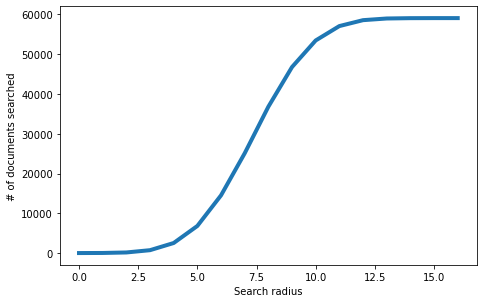

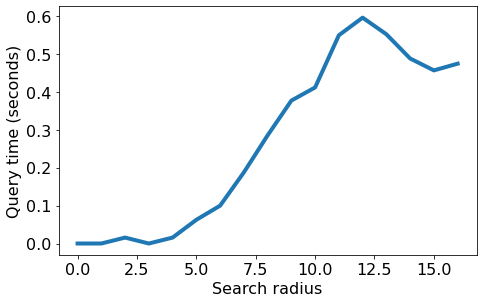

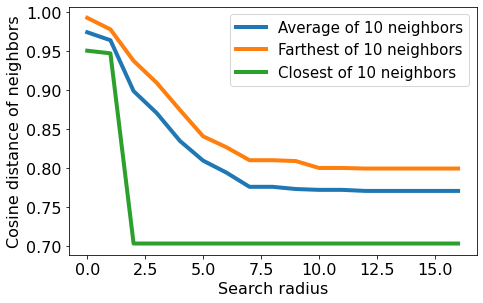

In [38]:
plt.figure(figsize=(7,4.5))
plt.plot(num_candidates_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(query_time_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(average_distance_from_query_history, linewidth=4, label='Average of 10 neighbors')
plt.plot(max_distance_from_query_history, linewidth=4, label='Farthest of 10 neighbors')
plt.plot(min_distance_from_query_history, linewidth=4, label='Closest of 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

### Quality metrics for neighbors

The above analysis is limited by the fact that it was run with a single query, namely Barack Obama. We should repeat the analysis for the entirety of data. Iterating over all documents would take a long time, so let us randomly choose 10 documents for our analysis.

For each document, we first compute the true 25 nearest neighbors, and then run LSH multiple times. We look at two metrics:

* Precision@10: How many of the 10 neighbors given by LSH are among the true 25 nearest neighbors?
* Average cosine distance of the neighbors from the query

Then we run LSH multiple times with different search radii.

In [39]:
def brute_force_query(vec, data, k):
    num_data_points = data.shape[0]
    
    # Compute distances for ALL data points in training set
    nearest_neighbors = pd.DataFrame(index=range(num_data_points))
    nearest_neighbors['distance'] = pairwise_distances(data, vec, metric='cosine').flatten()
    
    return nearest_neighbors.sort_values(['distance'], ascending=True)[:k]

In [40]:
max_radius = 17
precision = {i:[] for i in range(max_radius)}
average_distance  = {i:[] for i in range(max_radius)}
query_time  = {i:[] for i in range(max_radius)}

np.random.seed(0)
num_queries = 10
for i, ix in enumerate(np.random.choice(corpus.shape[0], num_queries, replace=False)):
    print('%s / %s' % (i, num_queries))
    ground_truth = set(brute_force_query(corpus[ix,:], corpus, k=25).index.values)
    # Get the set of 25 true nearest neighbors
    
    for r in range(1,max_radius):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=r)
        end = time.time()

        query_time[r].append(end-start)
        # precision = (# of neighbors both in result and ground_truth)/10.0
        precision[r].append(len(set(result.index.values) & ground_truth)/10.0)
        average_distance[r].append(result['distance'][1:].mean())

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10


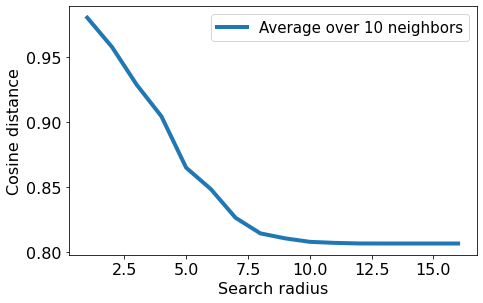

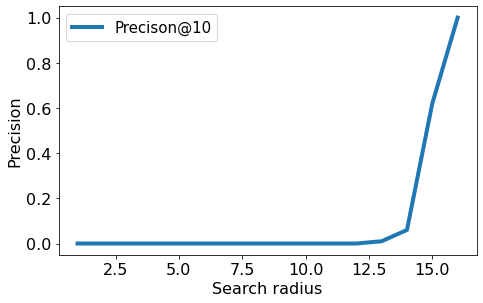

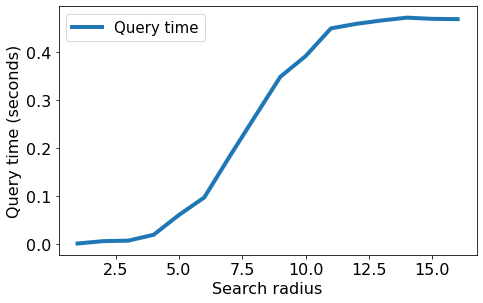

In [41]:
plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(average_distance[i]) for i in range(1,17)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(precision[i]) for i in range(1,17)], linewidth=4, label='Precison@10')
plt.xlabel('Search radius')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(query_time[i]) for i in range(1,17)], linewidth=4, label='Query time')
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

### Effect of number of random vectors

Let us now turn our focus to the remaining parameter: the number of random vectors. We run LSH with different number of random vectors, ranging from 5 to 20. We fix the search radius to 3.

Allow a few minutes for the following cell to complete.

In [42]:
precision = {i:[] for i in range(5,20)}
average_distance  = {i:[] for i in range(5,20)}
query_time = {i:[] for i in range(5,20)}
num_candidates_history = {i:[] for i in range(5,20)}
ground_truth = {}

np.random.seed(0)
num_queries = 10
docs = np.random.choice(corpus.shape[0], num_queries, replace=False)

for i, ix in enumerate(docs):
    ground_truth[ix] = set(brute_force_query(corpus[ix,:], corpus, k=25).index.values)
    # Get the set of 25 true nearest neighbors

for num_vector in range(5,20):
    print('num_vector = %s' % (num_vector))
    model = train_lsh(corpus, num_vector, seed=143)
    
    for i, ix in enumerate(docs):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=3)
        end = time.time()
        
        query_time[num_vector].append(end-start)
        precision[num_vector].append(len(set(result.index.values) & ground_truth[ix])/10.0)
        average_distance[num_vector].append(result['distance'][1:].mean())
        num_candidates_history[num_vector].append(num_candidates)

num_vector = 5
num_vector = 6
num_vector = 7
num_vector = 8
num_vector = 9
num_vector = 10
num_vector = 11
num_vector = 12
num_vector = 13
num_vector = 14
num_vector = 15
num_vector = 16
num_vector = 17
num_vector = 18
num_vector = 19


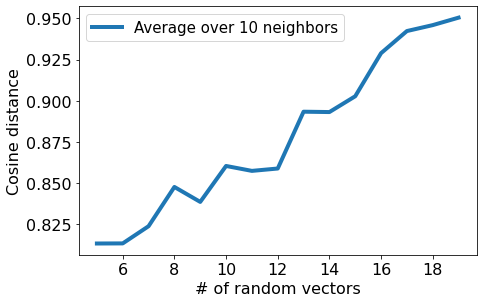

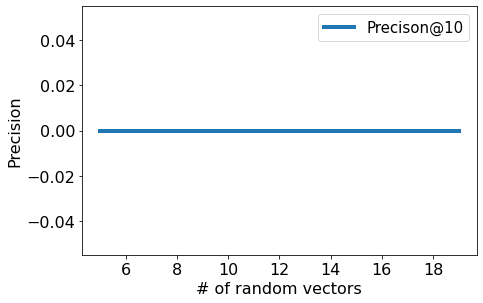

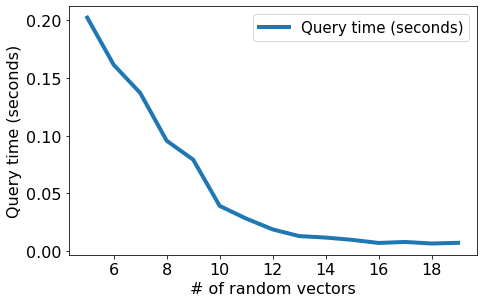

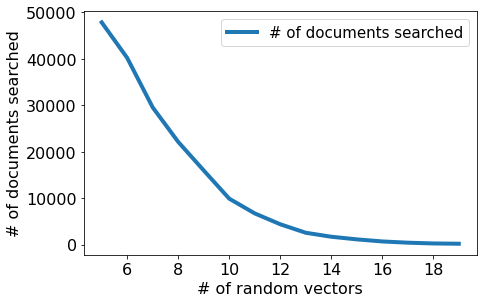

In [43]:
plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(average_distance[i]) for i in range(5,20)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('# of random vectors')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(precision[i]) for i in range(5,20)], linewidth=4, label='Precison@10')
plt.xlabel('# of random vectors')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(query_time[i]) for i in range(5,20)], linewidth=4, label='Query time (seconds)')
plt.xlabel('# of random vectors')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(num_candidates_history[i]) for i in range(5,20)], linewidth=4,
         label='# of documents searched')
plt.xlabel('# of random vectors')
plt.ylabel('# of documents searched')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()